# Data Analytics - ML25M 

### Imports

In [1]:
import torch
import time
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from torch.utils.tensorboard import SummaryWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

fix_random(42)


## Data Acquisition

movies.csv contains the following fields:

* movieId - a unique identifier for each movie.
* title - the title of the movie.
* genres - a pipe-separated list of genres for the movie.

It will be used to get the movie title and the genres.

In [2]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
genres = movies_df['genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genres], axis=1)
movies_df.drop('genres', axis=1, inplace=True)
movies_df.head(3)


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


genome-scores.csv contains the following fields:

* movieId - a unique identifier for each movie.
* tagId - a unique identifier for each tag.
* relevance - a score from 0.0 to 1.0 representing the relevance of the tag to the movie.

Combined with the tags.csv file, this will be used to assign tags and their relevance to each movie.

In [3]:
scores_df = pd.read_csv('./ml-25m/genome-scores.csv')
tags_df = pd.read_csv('./ml-25m/genome-tags.csv')
ratings_df = pd.read_csv('./ml-25m/ratings.csv')

df = movies_df.merge(scores_df, on='movieId')
df = df.merge(tags_df, on='tagId')
df = df.pivot_table(index=['movieId', 'title'], columns='tag', values='relevance', fill_value=0).reset_index().rename_axis(None, axis=1)

# average rating for each movie
ratings_df = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()
# round ratings to the nearest 0.5
ratings_df['rating'] = ratings_df['rating'].apply(lambda x: round(x * 2) / 2)

# # mode rating for each movie
# ratings_df = ratings_df.groupby(['movieId'])['rating'].agg(lambda x: x.value_counts().index[0]).reset_index()

df = ratings_df.merge(df, on='movieId')

# movieId and title are not needed for the model
df.drop(['movieId', 'title'], axis=1, inplace=True)

## Data visualization

In [4]:
print(f'Number of samples: {df.shape[0]}')
df.head(3)

Number of samples: 13816


,rating,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,4.0,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0.04050,0.01425,0.03050,0.035,0.14125,0.05775,0.039,0.02975,0.08475,0.02200
1,3.5,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0.05250,0.01575,0.01250,0.020,0.12225,0.03275,0.021,0.01100,0.10525,0.01975
2,3.0,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0.06275,0.01950,0.02225,0.023,0.12200,0.03475,0.017,0.01800,0.09100,0.01775


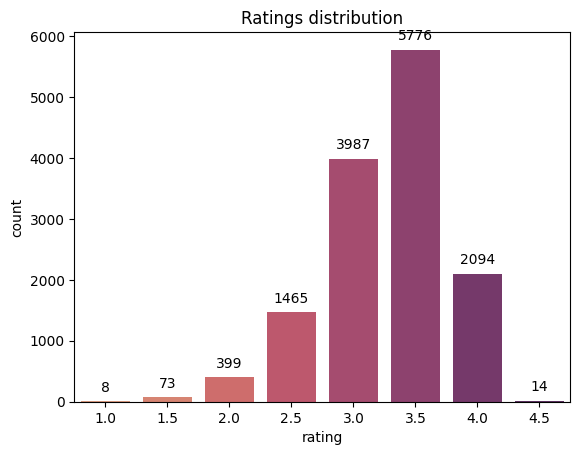

Mode:  0    3.5
Name: rating, dtype: float64
Median: 3.50
Std: 0.50


In [5]:
# Ratings distribution
sns.countplot(x='rating', data=df, palette='flare')
plt.title('Ratings distribution')
for p in plt.gca().patches:
    plt.gca().annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# mean, median, and standard deviation of ratings
print("Mode: ", df['rating'].mode())
print('Median: {:.2f}'.format(df['rating'].median()))
print('Std: {:.2f}'.format(df['rating'].std()))

## Data Preprocessing

In [6]:
N_LABELS = df.rating.nunique()
print(f'Number of labels: {N_LABELS}')

# looking for missing values and duplicates
print("Nan: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

Number of labels: 8
Nan:  0
Duplicates:  0


In [7]:
X = df.drop('rating', axis=1)
Y = df['rating']

# encode Y
Y = LabelEncoder().fit_transform(Y)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalization 


# PCA
# pca = PCA(n_components=2)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)
X_train = lda.transform(X_train)
X_test = lda.transform(X_test)

print(f'Number of training samples: {X_train.shape}')
print(f'Number of testing samples: {X_test.shape}')

results = pd.DataFrame(columns=['Model', 'Accuracy'])

Number of training samples: (11052, 7)
Number of testing samples: (2764, 7)


## Modeling

### Random Forest Classifier

In [8]:
# Create the model with 100 trees
random_forest = RandomForestClassifier(n_estimators=50,
                                bootstrap = True,
                                max_features = 'sqrt')

# Fit on training data
random_forest.fit(X_train, Y_train)

# accuracy
accuracy = random_forest.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame({'Model': 'Random Forest', 'Accuracy': accuracy}, index=[0])], ignore_index=True)

Accuracy: 0.863603473227207


### Logistic Classifier

In [9]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train, Y_train)

# accuracy
accuracy = logistic_classifier.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame({'Model': 'Logistic Regression', 'Accuracy': accuracy}, index=[0])], ignore_index=True)

Accuracy: 0.8607091172214182


/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Naive Bayes Classifier

In [10]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, Y_train)

# accuracy
accuracy = naive_bayes.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame({'Model': 'Naive Bayes', 'Accuracy': accuracy}, index=[0])], ignore_index=True)

Accuracy: 0.8418958031837916


### KNN Classifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, Y_train)

# accuracy
accuracy = knn.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame({'Model': 'KNN', 'Accuracy': accuracy}, index=[0])], ignore_index=True)

Accuracy: 0.8440665701881331


### SVM Classifier

In [12]:
svm = SVC()
svm.fit(X_train, Y_train)

# accuracy
accuracy = svm.score(X_test, Y_test)
print('Accuracy:', accuracy)

results = pd.concat([results, pd.DataFrame({'Model': 'SVM', 'Accuracy': accuracy}, index=[0])], ignore_index=True)

Accuracy: 0.8614327062228654


### Neural Network

In [13]:
# PyTorch Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: mps


In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')

# train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long)), batch_size=batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.long)), batch_size= 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.long)), batch_size= 64, shuffle=True)

Number of training samples: 9946
Number of validation samples: 1106


In [15]:
# Effective Number of Samples
def get_weights_effective_num_of_samples(no_of_classes, beta, samples_per_cls):
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    class_weights = (1.0 - beta) / np.array(effective_num)
    class_weights = class_weights / np.sum(class_weights)*no_of_classes
    return {i: w for i, w in enumerate(class_weights)}

weights = get_weights_effective_num_of_samples(N_LABELS, 0.999, np.bincount(Y_train))

In [16]:
def get_nn_model(input_size, hidden_size, num_classes, dropout_prob=0, depth=1):
    model = [
        torch.nn.Linear(input_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Dropout(dropout_prob)
    ]

    for i in range(depth):
        model.append(torch.nn.Linear(hidden_size, hidden_size))
        model.append(torch.nn.ReLU())
        model.append(torch.nn.Dropout(dropout_prob))

    model.append(torch.nn.Linear(hidden_size, num_classes))
    model.append(torch.nn.Softmax(dim=1))

    return torch.nn.Sequential(*model)

In [17]:
# hyperparameters
hidden_sizes = [64, 128, 256]
nums_epochs = [100]
depth = [2, 3, 4]
batch_sizes = [16, 32, 64, 128]
learning_rate = [0.01]
step_size_lr_decay = [10, 25, 50]
momentum = [0, 0.99]
dropout_prob = 0.2
patience = 10

hyperparameters = itertools.product(hidden_sizes, depth, nums_epochs, batch_sizes, learning_rate, step_size_lr_decay, momentum)

In [18]:
# training process
def train_model(model, criterion, optimizer, scheduler, epochs, data_loader, val_loader, device, writer):
    n_iter = 0

    best_val_loss = float('inf')
    epochs_since_last_improvement = 0
 
    start = time.time()

    for epoch in range(epochs):
        model.train()

        start_epoch = time.time()

        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device) 

            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred, targets)
            writer.add_scalar("Loss/train", loss, n_iter)

            # Backward pass
            loss.backward()
            optimizer.step()

            n_iter += 1

        scheduler.step()

        # Compute Val Loss
        labels, _, y_pred = test_model(model, val_loader, device)
        val_loss = criterion(y_pred, labels)
        writer.add_scalar("Loss/val", val_loss, epoch)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')
            epochs_since_last_improvement = 0
        else:
            epochs_since_last_improvement += 1

        if epochs_since_last_improvement >= patience:
            break

        print('Epoch [{}/{}] - {:.2f} seconds - loss: {:.4f} - val_loss: {:.4f} - patience: {}'.format(epoch+1, epochs, time.time() - start_epoch, loss.item(), val_loss.item(), epochs_since_last_improvement), end='\r')
        
    print('\nTraining ended after {:.2f} seconds'.format(time.time() - start))

    # Restore best model
    model.load_state_dict(torch.load('models/best_model.pth'))
    return model

# evaluation process
def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)

            y_pred.append(model(data))
            y_test.append(targets)

    y_pred = torch.cat(y_pred, dim=0)
    y_test = torch.cat(y_test, dim=0)

    y_pred_c = torch.argmax(y_pred, dim=1)

    return y_test, y_pred_c, y_pred


In [19]:
best_acc = 0
best_model = None

if os.path.exists('best_model.pth'):
    # load best model
    best_model = get_nn_model(X_train.shape[1], 64, N_LABELS, dropout_prob=dropout_prob, depth=2)
    best_model.load_state_dict(torch.load('best_model.pth'))
    best_model.to(device)
    best_model.eval()
    y_test, y_pred_c, y_pred = test_model(best_model, test_loader, device)
    metrics = classification_report(y_test.cpu(), y_pred_c.cpu(), output_dict=True, zero_division=0)
    best_acc = metrics['accuracy']


for hidden_size, depth, num_epochs, batch, lr, step_size, momentum in hyperparameters:
    
    if not os.path.exists('models'):
        os.makedirs('models')

    print("\nTraining with hidden_size={}, depth={}, num_epochs={}, batch={}, lr={}, step_size={}, momentum={}".format(hidden_size, depth, num_epochs, batch, lr, step_size, momentum))
    log_name = "dim:"+str(hidden_size)+"_depth:"+str(depth)+"_epochs:"+str(num_epochs)+"_batch:"+str(batch)+"_lr:"+str(lr)+"_step_size:"+str(step_size)+"_momentum:"+str(momentum)
    
    if os.path.exists('runs/'+log_name):
        print("Model already trained, skipping...")
        continue

    # start tensorboard
    writer = SummaryWriter('runs/'+log_name)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long)), batch_size=batch, shuffle=True)

    model = get_nn_model(X_train.shape[1], hidden_size, N_LABELS, dropout_prob, depth=depth)
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(weights.values()), dtype=torch.float32).to(device))
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.1)

    # train
    model = train_model(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, device, writer)

    # validate
    y_test, y_pred_c, y_pred = test_model(model, test_loader, device)

    metrics = classification_report(y_test.cpu(), y_pred_c.cpu(), output_dict=True, zero_division=0)
    writer.add_scalar('metrics/test accuracy', metrics['accuracy'])

    writer.add_hparams({'hidden_size': hidden_size, 'depth': depth, 'num_epochs': num_epochs, 'batch': batch, 'lr': lr, 'step_size': step_size, 'momentum': momentum}, {'hparam/accuracy': metrics['accuracy']})

    if metrics['accuracy'] > best_acc:
        best_acc = metrics['accuracy']
        best_model = model
        torch.save(model.state_dict(), 'best_model.pth')

    print("Best accuracy so far: {:.2f}".format(best_acc))
    
    torch.save(model.state_dict(), 'models/'+log_name+'.pth')

    writer.flush()

writer.close()


Training with hidden_size=64, depth=2, num_epochs=50, batch=16, lr=0.01, step_size=10, momentum=0
Epoch [50/50] - 3.27 seconds - loss: 1.6306 - val_loss: 1.4627 - patience: 2
Training ended after 168.28 seconds

Training with hidden_size=64, depth=2, num_epochs=50, batch=16, lr=0.01, step_size=10, momentum=0.99
Epoch [10/50] - 3.65 seconds - loss: 1.8983 - val_loss: 1.9509 - patience: 9
Training ended after 39.58 seconds

Training with hidden_size=64, depth=2, num_epochs=50, batch=16, lr=0.01, step_size=25, momentum=0
Epoch [50/50] - 3.36 seconds - loss: 1.3390 - val_loss: 1.4490 - patience: 4
Training ended after 166.41 seconds

Training with hidden_size=64, depth=2, num_epochs=50, batch=16, lr=0.01, step_size=25, momentum=0.99
Epoch [11/50] - 3.39 seconds - loss: 1.8246 - val_loss: 1.9479 - patience: 9
Training ended after 41.96 seconds

Training with hidden_size=64, depth=2, num_epochs=50, batch=16, lr=0.01, step_size=50, momentum=0
Epoch [35/50] - 3.43 seconds - loss: 1.6050 - val

In [20]:
# test
y_test, y_pred_c, y_pred = test_model(best_model, test_loader, device)
print(classification_report(y_test.cpu(), y_pred_c.cpu()))
accuracy = accuracy_score(y_test.cpu(), y_pred_c.cpu())

results = pd.concat([results, pd.DataFrame({'Model': 'NeuralNetwork', 'Accuracy': accuracy}, index=[0])], ignore_index=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         9
           2       0.73      0.79      0.76        80
           3       0.79      0.75      0.77       284
           4       0.84      0.86      0.85       804
           5       0.89      0.87      0.88      1159
           6       0.83      0.88      0.85       426
           7       0.00      0.00      0.00         1

    accuracy                           0.85      2764
   macro avg       0.51      0.52      0.51      2764
weighted avg       0.85      0.85      0.85      2764



/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

### Deep Learning for Tabular Data

[PyTorch Tabular](https://github.com/manujosephv/pytorch_tabular#installation)

## Evaluation